In [28]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.datasets import fetch_mldata
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve, roc_curve, roc_auc_score
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

%matplotlib inline

import warnings
# warnings.filterwarnings('ignore') # To ingnore warnings entirely
warnings.filterwarnings(action="once") # To see warning only once

In [2]:
mnist = fetch_mldata("MNIST original")
X,y = mnist["data"], mnist["target"]

## Show Images

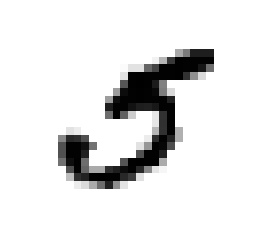

5.0

In [3]:
some_digit = X[36000]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap=matplotlib.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()
y[36000]

## Split into train and test

In [4]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

## Binary Classifier

In [5]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [6]:
sgd_clf = SGDClassifier() # Add `random_state=42` to make training consistent
sgd_clf.fit(X_train, y_train_5)
# Some digit was created earlier and has the label of 5, the other digit is a 4
sgd_clf.predict([some_digit, X_test[4769]])

/home/zhach/miniconda2/lib/python2.7/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


array([ True, False], dtype=bool)

## Straight Cross Validation

In [7]:
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([ 0.9396 ,  0.95315,  0.95425])

In [8]:
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool) # Always return 1 to say its not a 5

In [9]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([ 0.90955,  0.9106 ,  0.9088 ])

## Let's Confuse the Martices!

In [10]:
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
confusion_matrix(y_train_5, y_train_pred)

array([[53666,   913],
       [ 1517,  3904]])

In [11]:
precision_score(y_train_5, y_train_pred)

0.81046294374091754

In [12]:
recall_score(y_train_5, y_train_pred)

0.72016233167312305

In [13]:
f1_score(y_train_5, y_train_pred)

0.76264895487399886

##  Precision/Recall tradeoff

In [14]:
def plot_p_r_vs_t(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="center left")
    plt.ylim([0, 1])

def plot_p_vs_r(precisions, recalls):
    plt.plot(recalls, precisions, "b-")
    plt.axis([0, 1, 0, 1])
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")

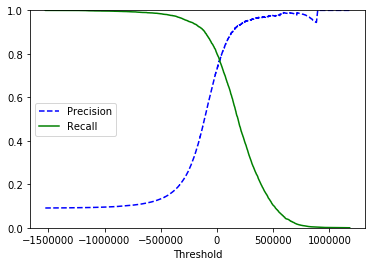

In [15]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)
plot_p_r_vs_t(precisions, recalls, thresholds)
plt.show()

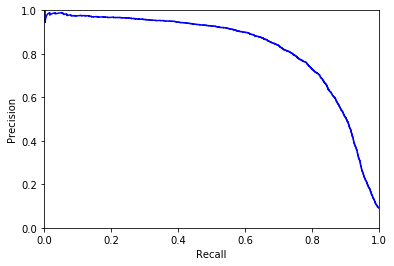

In [16]:
plot_p_vs_r(precisions, recalls)
plt.show()

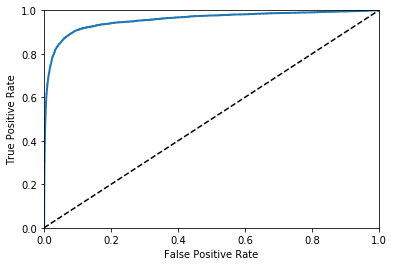

In [17]:
fpr, tpr, _ = roc_curve(y_train_5, y_scores)
plot_roc_curve(fpr, tpr)
plt.show()

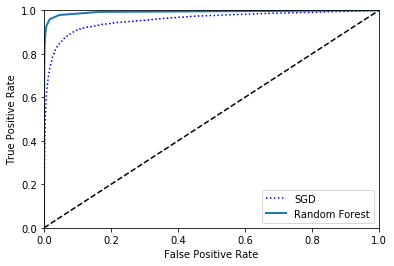

SGD AUC: 0.956258822057
Random Forest AUC: 0.992844413906


In [18]:
forest_clf = RandomForestClassifier() # Add `random_state=42` to make training consistent
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, _ = roc_curve(y_train_5, y_scores_forest)

plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()
print "SGD AUC:", roc_auc_score(y_train_5, y_scores)
print "Random Forest AUC:", roc_auc_score(y_train_5, y_scores_forest)

## Multiclass Classifier

In [19]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([ 5.])

In [20]:
some_digit_scores = sgd_clf.decision_function([some_digit])
print some_digit_scores
print "Highest Score: ", np.argmax(some_digit_scores)

[[-246917.04140297 -505759.39928006 -387894.49589532   -8774.72794732
  -351067.51545715  107638.28425611 -746633.78451664 -342321.21697218
  -684830.7486437  -696390.71485897]]
Highest Score:  5


In [21]:
forest_clf.fit(X_train, y_train)
print forest_clf.predict([some_digit])
print forest_clf.predict_proba([some_digit])

[ 5.]
[[ 0.   0.   0.   0.2  0.   0.7  0.   0.   0.1  0. ]]


In [22]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
print "SGD: ", cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")
print "Forest: ", cross_val_score(forest_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

SGD:  [ 0.90996801  0.90864543  0.90928639]
Forest:  [ 0.94176165  0.94269713  0.94144122]


## Error Analysis

SGD


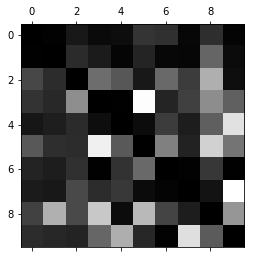

Forest


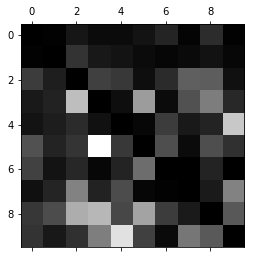

In [23]:
sgd_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
forest_train_pred = cross_val_predict(forest_clf, X_train_scaled, y_train, cv=3)

sgd_conf_mat = confusion_matrix(y_train, sgd_train_pred)
forest_conf_mat = confusion_matrix(y_train, forest_train_pred)

row_sums = sgd_conf_mat.sum(axis=1, keepdims=True)
sgd_norm_conf_mat = sgd_conf_mat / row_sums.astype(np.float64)
forest_norm_conf_mat = forest_conf_mat / row_sums.astype(np.float64)

np.fill_diagonal(sgd_norm_conf_mat, 0)
np.fill_diagonal(forest_norm_conf_mat, 0)

print "SGD"
plt.matshow(sgd_norm_conf_mat, cmap=plt.cm.gray)
plt.show()
print "Forest"
plt.matshow(forest_norm_conf_mat, cmap=plt.cm.gray)
plt.show()

## Multilabel Classification

In [24]:
y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
# KNN doesn't like scaled features, so using X_train and not X_train_scaled
knn_clf.fit(X_train, y_multilabel)

knn_clf.predict([some_digit])

array([[False,  True]], dtype=bool)

In [26]:
# y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.97651981387752995

## Multioutput Classification

In [ ]:
some_index = 10000

noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])